In [ ]:
# !pip install -Uqq more_itertools

In [ ]:
import inspect
class InitMixin:
    @classmethod
    def fmt_init(cls): 
        sig = inspect.signature(cls.__init__)
        params = []
        for param in sig.parameters.values():
            if param.kind in (param.VAR_POSITIONAL, param.VAR_KEYWORD):
                continue
            if param.name == "self":
                continue
            fmt = param.name
            if param.default is not param.empty:
                 fmt += f"={param.default}"
            params.append(fmt)
        return ", ".join(params)
    def __repr__(self):
        return f"{self.__class__.__name__}({self.fmt_init()})"
    def __str__(self):
        return repr(self)

In [ ]:
class Module(InitMixin):
    def __call__(self, *args, **kwargs):
        params = list(inspect.signature(self.forward).parameters.values())
        output = self.forward(*args, **kwargs)
        inputs = dict(zip([p.name for p in params], list(args) + list(kwargs.values())))
        self.cache(**inputs, out=output)
        return output
    def cache(self, **kwargs):
        self.__dict__.update(**kwargs)
    def get(self, key, *keys):
        keys = [key] + list(keys)
        return [self.__dict__.get(k) for k in keys]
    def backward(self):
        raise NotImplementedError()

In [ ]:
class New(Module):
    def __init__(self, a, b, *args, c=3, **kwargs):
        self.a, self.b, self.c = a, b, c
    def forward(self, x, y, z=1):
        return x + y*z
    
new = New(1, 2)
print(new(1, 2, 3))
print(new.__dict__)

7
{'a': 1, 'b': 2, 'c': 3, 'x': 1, 'y': 2, 'z': 3, 'out': 7}


In [ ]:
import numpy as np
import torch
from torch import tensor as t
from torch.nn import functional as F

def test(t1, t2, eps=1e-8): assert torch.allclose(t1, t2, atol=eps)

def grad(t): return t.requires_grad_(True)

In [ ]:
np.random.seed(1)

## MSE Loss

$$
\begin{aligned}
L &= MSE(y, \hat{y}) = \mathbb{E}(y - \hat{y})^2 = \mathbb{E}(d)^2 \\
\frac{dL}{d\hat{y}} &= 2 \times \mathbb{E}(d) = 2\frac{d}{N}
\end{aligned}
$$

In [ ]:
class MSE(Module):
    def forward(self, pred, gt):
        return (pred - gt).pow(2).mean()
    def backward(self):
        d = self.pred - self.gt
        self.pred.g = 2 * d / d.shape[0]

In [ ]:
x, y = grad(t([1.5, 0.3, 2.0])), grad(t([1., 1., 3.]))

mse = MSE()
my, ref = mse(x, y), F.mse_loss(x, y)
test(my, ref)

mse.backward()
ref.backward()
test(x.g, x.grad)

## ReLU

In [ ]:
class ReLU(Module):
    def forward(self, inp): return inp.clamp_min(0)
    def backward(self): self.inp.g = (self.inp > 0).float() * self.out.g

In [ ]:
x, y = grad(t([-1.5, 0., 2.0])), grad(t([1., 1., 3.]))

F.mse_loss(F.relu(x), y).backward()

mse, relu = MSE(), ReLU()
mse(relu(x), y)
mse.backward()
relu.backward()

test(x.g, x.grad)

## Linear

In [ ]:
class Linear(Module):
    def __init__(self, W, b):
        super().__init__()
        self.W, self.b = W, b
    def forward(self, inp): return inp @ self.W + self.b
    def backward(self):
        i, o = self.inp, self.out
        i.g = o.g @ self.W.t()
        self.W.g = i.t() @ o.g
        self.b.g = o.g.sum(0)  # same bias for all rows
    def __repr__(self):
        return f"{self.__class__.__name__}({list(self.W.shape)})"

In [ ]:
X = torch.tensor([
    [ 1, -2, 3, 1],
    [ 0,  1, 0, 1],
    [-1,  0, 1, 0]
]).float()
y = torch.tensor([1, 0, 3]).unsqueeze(-1)
X, y

(tensor([[ 1., -2.,  3.,  1.],
         [ 0.,  1.,  0.,  1.],
         [-1.,  0.,  1.,  0.]]),
 tensor([[1],
         [0],
         [3]]))

In [ ]:
W1 = grad(torch.eye(4))
b1 = grad(torch.ones(X.shape[0], W1.shape[-1]))
W2 = grad(t([1., 0., -1., 1.]).unsqueeze(-1))
b2 = grad(torch.ones((X.shape[0], W2.shape[1])))

(F.relu(F.relu(X@W1 + b1)@W2 + b2) - y).pow(2).mean().backward()

mse = MSE()
lin1, rel1 = Linear(W1, b1), ReLU()
lin2, rel2 = Linear(W2, b2), ReLU()

mse(rel2(lin2(rel1(lin1(X)))), y)
mse.backward()
rel2.backward()
lin2.backward()
rel1.backward()
lin1.backward()

[test(x.g, x.grad) for x in (W1, W2)]
[test(x.g, x.grad.sum(0)) for x in (b1, b2)];

## Model

In [ ]:
from functools import reduce
class MLP(Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
    def forward(self, inp):
        return reduce(lambda x, l: l(x), self.layers, inp)
    def backward(self):
        [l.backward() for l in self.layers[::-1]]
    def __repr__(self):
        fmt = "".join(map(lambda l: f"  {l}\n", self.layers))
        return f"MLP(layers=[\n{fmt}])"

In [ ]:
W1 = grad(torch.eye(4))
b1 = grad(torch.ones(X.shape[0], W1.shape[-1]))
W2 = grad(t([1., 0., -1., 1.]).unsqueeze(-1))
b2 = grad(torch.ones(X.shape[0], W2.shape[1]))

mse = MSE()
lin1, rel1 = Linear(W1, b1), ReLU()
lin2, rel2 = Linear(W2, b2), ReLU()
model = MLP([lin1, rel1, lin2, rel2])

mse(model(X), y)
mse.backward()
model.backward()

In [ ]:
W1.g

tensor([[ 0.,  0.,  0.,  0.],
        [ 2.,  0., -2.,  2.],
        [ 0.,  0.,  0.,  0.],
        [ 2.,  0., -2.,  2.]], grad_fn=<MmBackward0>)

## Training

In [ ]:
from more_itertools import chunked

In [ ]:
def linear(i: int, o: int, init=None) -> Linear:
    w = torch.randn((i, o))
    b = torch.ones(o)
    if init is not None: init(w), init(b)
    return Linear(w, b)

In [ ]:
def mlp(sizes):
    layers = []
    for i, o in zip(sizes[:-1], sizes[1:]):
        layers += [linear(i, o), ReLU()]
    layers = layers[:-1]
    return MLP(layers)

In [ ]:
mlp([784, 10, 1])

MLP(layers=[
  Linear([784, 10])
  ReLU()
  Linear([10, 1])
])

In [ ]:
MNIST_URL = "https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true"

In [ ]:
import gzip
import pickle
from pathlib import Path
from urllib.request import urlretrieve

In [ ]:
def get_mnist(log=True):
    path_data = Path("data")
    path_data.mkdir(exist_ok=True)
    path_gz = path_data/"mnist.pkl.gz"
    if not path_gz.exists(): 
        urlretrieve(MNIST_URL, path_gz)
    with gzip.open(path_gz, 'rb') as f: 
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    data = x_train, y_train, x_valid, y_valid
    if log:
        print(f"train: x.shape={x_train.shape}, y.shape={y_train.shape}")
        print(f"valid: x.shape={x_valid.shape}, y.shape={y_valid.shape}")
    return data

In [ ]:
from fastai.vision.all import show_images, set_seed

In [ ]:
set_seed(1)

In [ ]:
n = 1000
x_full, y_full, _, _ = get_mnist(False)
mask = y_full == 5
x_0 = x_full[mask][:n]
x_1 = x_full[~mask][:n]
y_0 = np.ones(x_0.shape[0])
y_1 = np.zeros_like(y_0)
x, y = np.vstack([x_0, x_1]), np.hstack([y_0, y_1])
idx = np.arange(x.shape[0])
np.random.shuffle(idx)
x, y = x[idx], y[idx]

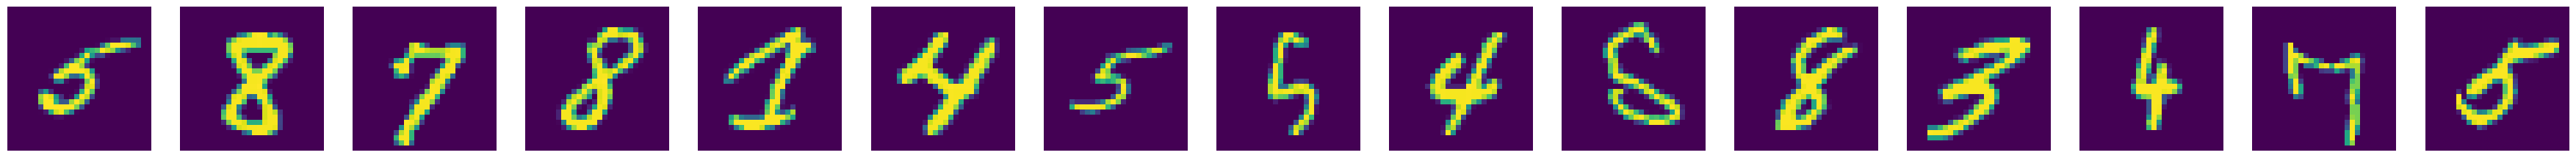

In [ ]:
show_images([im.reshape(28, 28) for im in x[:15]])

In [ ]:
from more_itertools import chunked
lr = 0.005
n_trn = int(x.shape[0] * 0.8)
mse = MSE()
model = mlp([784, 10, 1])

x_trn, y_trn = x[:n_trn], y[:n_trn]
x_val, y_val = x[n_trn:], y[n_trn:]

for epoch in range(40):
    val, cnt = 0, 0
    
    idx = np.arange(len(x_trn))
    np.random.shuffle(idx)
    x_trn, y_trn = x_trn[idx], y_trn[idx]
    
    for xb, yb in zip(chunked(x_trn, 10), chunked(y_trn, 10)):
        xb, yb = np.vstack(xb), np.asarray(yb, dtype=np.float32)
        xb, yb = torch.as_tensor(xb), torch.as_tensor(yb).view(-1, 1)
        logits = model(xb)
        val += mse(logits, yb)
        cnt += len(yb)
        mse.backward()
        model.backward()
        for lin in (model.layers[0], model.layers[-1]):
            lin.W -= lr * lin.W.g
            lin.b -= lr * lin.b.g.sum(0)
            lin.W.g.zero_()
            lin.b.g.zero_()

    print(f"Loss at epoch {epoch+1:2d}: {val/cnt:3.4f}")

Loss at epoch  1: 0.2846
Loss at epoch  2: 0.0328
Loss at epoch  3: 0.0282
Loss at epoch  4: 0.0259
Loss at epoch  5: 0.0260
Loss at epoch  6: 0.0238
Loss at epoch  7: 0.0232
Loss at epoch  8: 0.0233
Loss at epoch  9: 0.0238
Loss at epoch 10: 0.0231
Loss at epoch 11: 0.0227
Loss at epoch 12: 0.0230
Loss at epoch 13: 0.0232
Loss at epoch 14: 0.0223
Loss at epoch 15: 0.0221
Loss at epoch 16: 0.0218
Loss at epoch 17: 0.0222
Loss at epoch 18: 0.0221
Loss at epoch 19: 0.0218
Loss at epoch 20: 0.0217
Loss at epoch 21: 0.0219
Loss at epoch 22: 0.0220
Loss at epoch 23: 0.0213
Loss at epoch 24: 0.0210
Loss at epoch 25: 0.0216
Loss at epoch 26: 0.0209
Loss at epoch 27: 0.0208
Loss at epoch 28: 0.0207
Loss at epoch 29: 0.0217
Loss at epoch 30: 0.0207
Loss at epoch 31: 0.0205
Loss at epoch 32: 0.0203
Loss at epoch 33: 0.0204
Loss at epoch 34: 0.0206
Loss at epoch 35: 0.0205
Loss at epoch 36: 0.0208
Loss at epoch 37: 0.0209
Loss at epoch 38: 0.0205
Loss at epoch 39: 0.0200
Loss at epoch 40: 0.0203


In [ ]:
fives = (model(torch.as_tensor(x_val)).clip(0, 1) >= 0.5).sum(1).numpy()

In [ ]:
(fives == y_val).mean()

0.6375

$$
\begin{align}
f(X, W, b) &= X \times W + b = H + b\\
\\
X_{m,n} &= 
\begin{pmatrix}
x_{1,1} & x_{1,2} & \cdots & x_{1,n} \\
x_{2,1} & x_{2,2} & \cdots & x_{2,n} \\
\vdots  & \vdots  & \ddots & \vdots  \\
x_{m,1} & x_{m,2} & \cdots & x_{m,n}
\end{pmatrix}\\
\\
W_{n,k} &=
\begin{pmatrix}
w_{1,1} & w_{1,2} & \cdots & w_{1,k} \\
w_{2,1} & w_{2,2} & \cdots & w_{2,k} \\
\vdots  & \vdots  & \ddots & \vdots  \\
w_{n,1} & w_{n,2} & \cdots & w_{n,k}
\end{pmatrix} \\
\\
H_{m,k} &=
\begin{pmatrix}
h_{1,1} & \cdots & h_{1,k} \\
\vdots  & \ddots & \vdots  \\
h_{m,1} & \cdots & h_{m,k} \\
\end{pmatrix} \\
\\
b &= \left(b_{m,k}\right)
\end{align}
$$